# Caso Técnico Xepelin
# Análisis Exploratorio
#### Florencia Margara
#### Fecha: 2022-08-26

## Import Libs



In [87]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import scipy.stats as st
import calendar

# Series de Tiempos
# ==============================================================================
import statsmodels.api as sm
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Configuración
# ==============================================================================
from IPython.display import display, HTML
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 500)

## Load data 

In [ ]:
df = pd.read_csv('data/data_test(2).csv', parse_dates=['paidAt'])

In [ ]:
df.head()

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status
0,53,10,18660729,2022-04-23,1490.46,0.00,PAID
1,93,11,18660730,2021-11-20,6418.28,624.48,PAID
2,122,12,18660731,2021-10-19,27979.20,10520.15,PAID
3,85,13,18660732,2021-11-13,183070.77,79421.63,PAID
4,87,14,18660733,2022-03-23,20532.00,20532.00,PAID


In [ ]:
## Add new columns
# ==============================================================================
df['pctFinanced'] = df['amountfinancedByXepelin']/df['amount']
df['flgFinanced'] = df['amountfinancedByXepelin'].apply(lambda x: 1 if x != 0 else 0)
df['period'] = df['paidAt'].dt.to_period('M').dt.to_timestamp()

In [ ]:
## Change Data Types
# ==============================================================================
df = df.astype({"PayerId": str, "ReceiverId": str, "invoiceId":str, "flgFinanced":bool})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PayerId                  1200 non-null   object        
 1   ReceiverId               1200 non-null   object        
 2   invoiceId                1200 non-null   object        
 3   paidAt                   892 non-null    datetime64[ns]
 4   amount                   1200 non-null   float64       
 5   amountfinancedByXepelin  1200 non-null   float64       
 6   status                   1200 non-null   object        
 7   pctFinanced              1200 non-null   float64       
 8   flgFinanced              1200 non-null   bool          
 9   period                   892 non-null    datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(3), object(4)
memory usage: 85.7+ KB


## Looking for missing data

<AxesSubplot:>

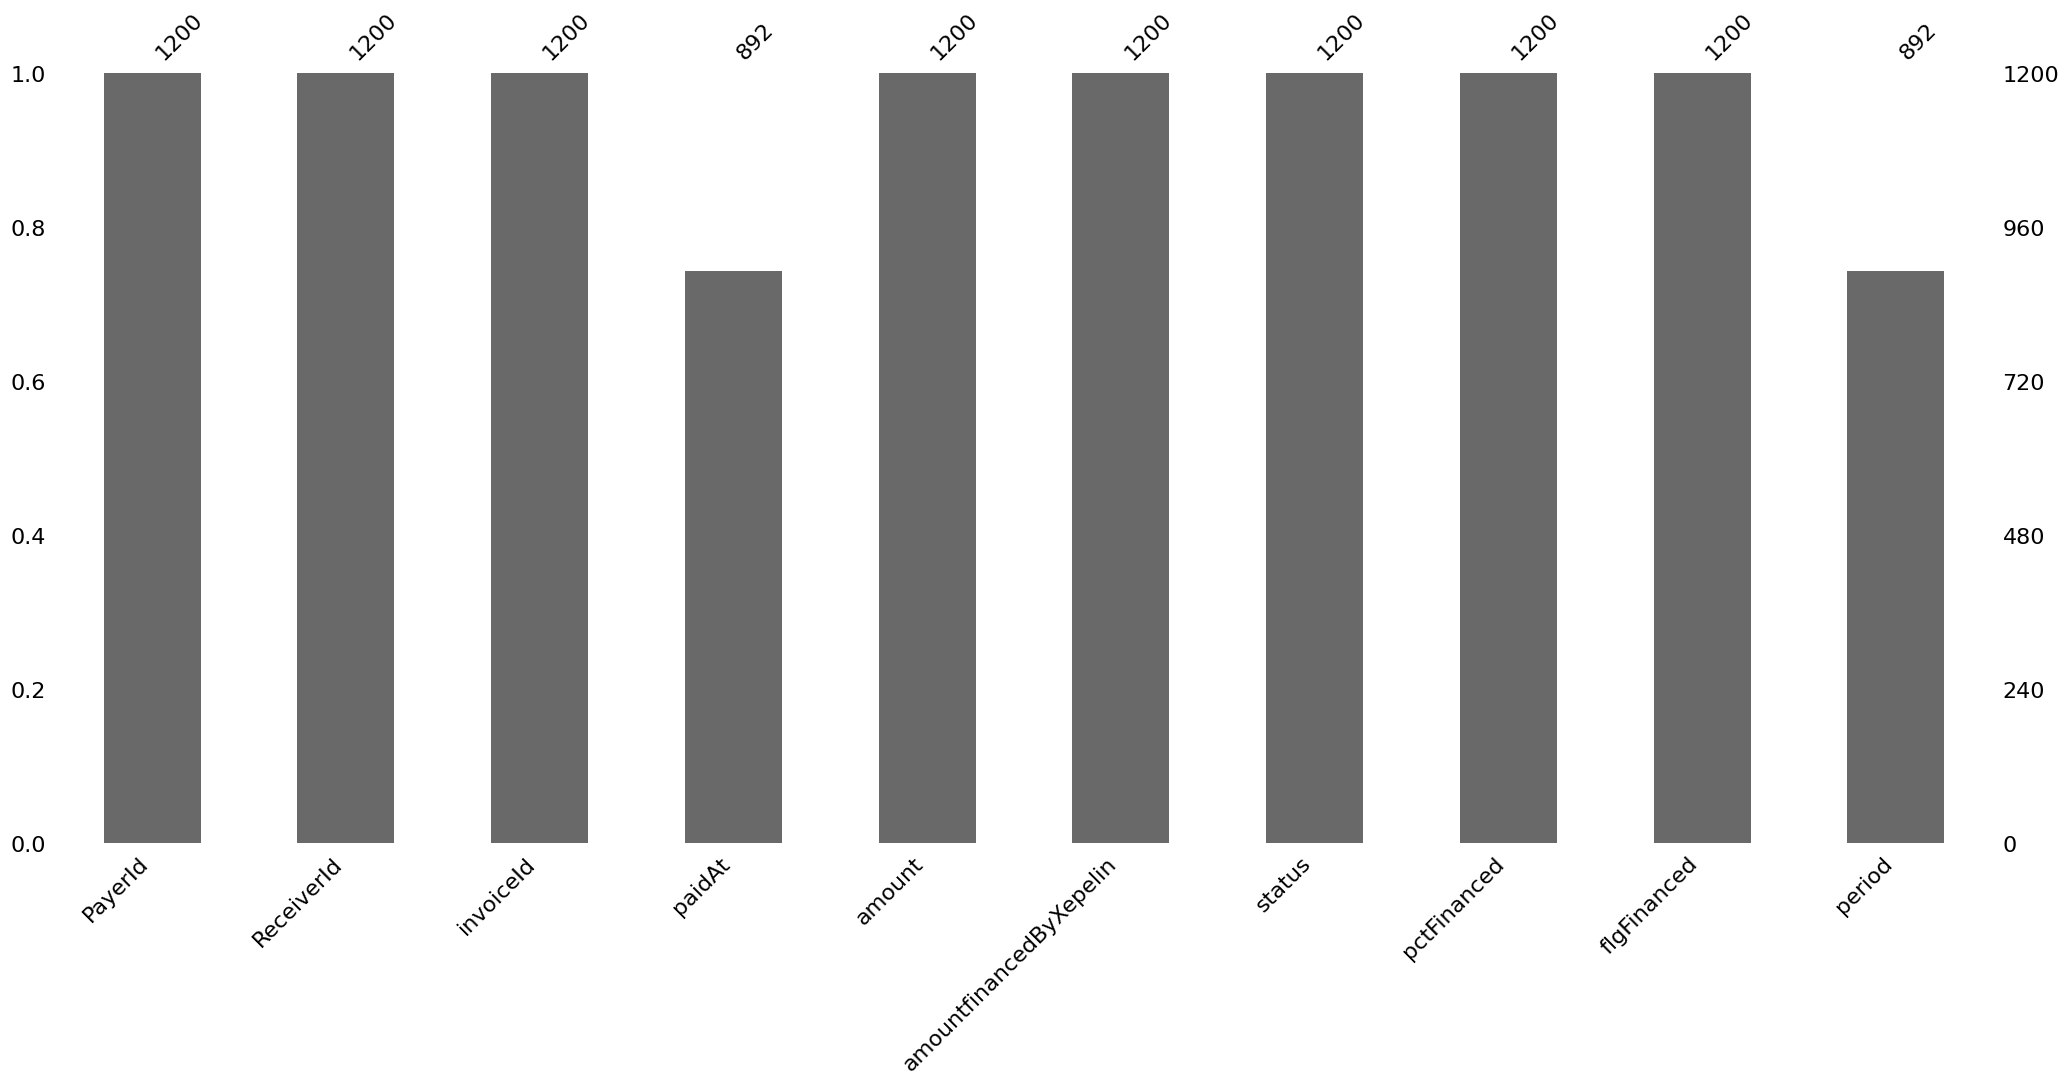

In [ ]:
msno.bar(df)

## La variable 'paidAt' tiene 308 valores faltantes. ¿Puede ser porque no se efectúa la transacción?

## Describe Data

### Categorical Features

<AxesSubplot:ylabel='None'>

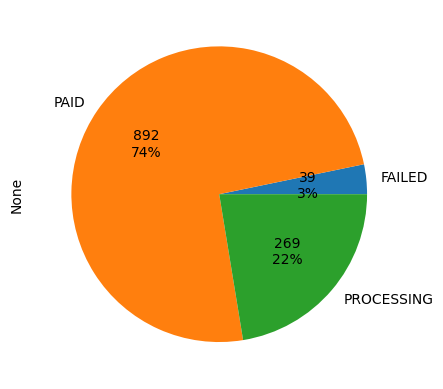

In [ ]:
### Veamos la variable 'status' en búsqueda de conocer la proporción
# ==============================================================================

def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

df.groupby('status').size().plot(kind='pie', autopct=label_function)

# Confirmamos que los nulos en paidAt es porque no se efectua la transacción ya que failed+processing=308

<AxesSubplot:ylabel='None'>

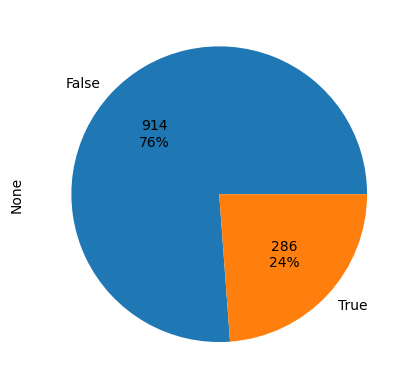

In [ ]:
### Veamos la variable 'flgFinanced' en búsqueda de conocer la proporción
# ==============================================================================

df.groupby('flgFinanced').size().plot(kind='pie', autopct=label_function)

### Numerical Features

In [ ]:
df.describe(datetime_is_numeric=True)

,paidAt,amount,amountfinancedByXepelin,pctFinanced,period
count,892,1200.00,1200.00,1200.00,892
mean,2022-03-12 06:57:04.304932864,27852.17,17493.03,0.15,2022-02-26 05:00:16.143497728
min,2021-10-09 00:00:00,58.16,0.00,0.00,2021-10-01 00:00:00
25%,2022-02-05 00:00:00,1251.81,0.00,0.00,2022-02-01 00:00:00
50%,2022-03-21 00:00:00,1490.46,0.00,0.00,2022-03-01 00:00:00
75%,2022-04-10 00:00:00,4120.86,0.00,0.00,2022-04-01 00:00:00
max,2022-05-31 00:00:00,3370741.92,3370741.92,1.00,2022-05-01 00:00:00
std,NaN,141489.87,122901.58,0.33,NaN


In [ ]:
# Observamos datos agregados por 'Payerid'
# ==============================================================================

df_payers= df.groupby('PayerId').agg(freq=('invoiceId', 'count')
                         ,totalAmount=('amount', 'sum')
                         ,meanAmount=('amount', 'mean')
                         ,totalFinanced=('amountfinancedByXepelin', 'sum')
                         ,meanFinanced=('amountfinancedByXepelin', 'mean')
                         ,meanPctFinanced=('pctFinanced', 'mean')
                         )\
                    .sort_values('totalAmount', ascending = False)\
                    .head(15)
df_payers

,freq,totalAmount,meanAmount,totalFinanced,meanFinanced,meanPctFinanced
PayerId,,,,,,
106,8,3386494.82,423311.85,3370741.92,421342.74,0.12
8,10,1999144.72,199914.47,863976.59,86397.66,0.41
140,5,1497194.21,299438.84,1404452.75,280890.55,0.20
109,4,1459635.66,364908.91,421056.26,105264.07,0.09
7,6,1290997.50,215166.25,1285010.20,214168.37,0.17
175,8,751382.16,93922.77,743303.92,92912.99,0.25
67,10,734971.70,73497.17,275436.70,27543.67,0.22
66,6,731434.63,121905.77,232579.51,38763.25,0.60
184,11,681421.32,61947.39,100416.36,9128.76,0.01


In [ ]:
# Coef. correlación entre totalAmount y meanPctFinanced por PayerId
# ==============================================================================
corr= np.corrcoef(df_payers['totalAmount'], df_payers['meanPctFinanced'])[0,1]
print(f'El coeficiente de correlacióin entre el monto total pagado y la media del porcentaje financiado es {corr}')

# No hay una relación lineal positiva entre montos y porcentaje de financiación

El coeficiente de correlacióin entre el monto total pagado y la media del porcentaje financiado es -0.1496160535942007


In [ ]:
# Observamos proporción total finanaciada por 'Payerid'
# ==============================================================================

totalByPayer = df.groupby('PayerId').agg(totalAmount=('amount', 'sum')).reset_index()
totalByPayer['pctAmountPayer'] = totalByPayer['totalAmount'] / sum(totalByPayer['totalAmount'])

totalByPayer.sort_values(by='pctAmountPayer', ascending=False).head(15)

,PayerId,totalAmount,pctAmountPayer
8,106,3386494.82,0.10
178,8,1999144.72,0.06
46,140,1497194.21,0.04
11,109,1459635.66,0.04
167,7,1290997.50,0.04
84,175,751382.16,0.02
164,67,734971.70,0.02
163,66,731434.63,0.02
94,184,681421.32,0.02
64,157,598924.53,0.02


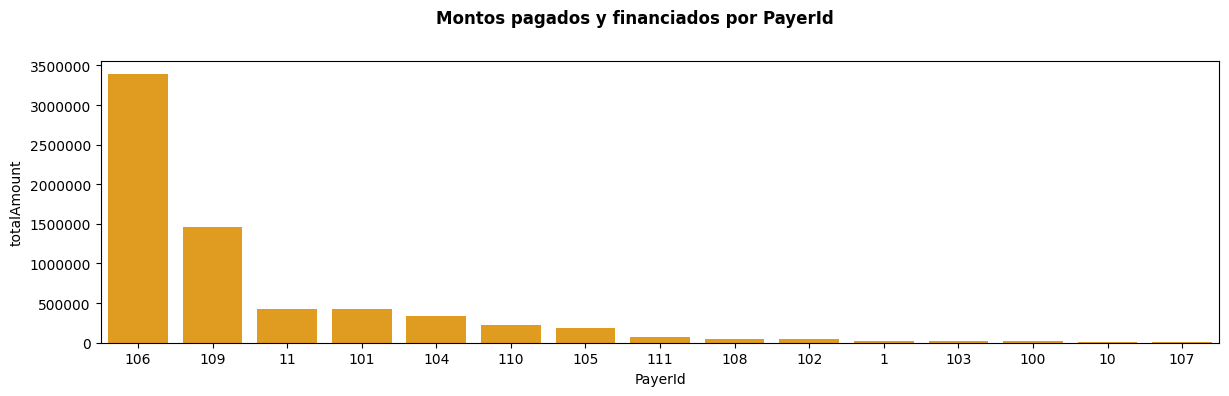

In [ ]:
# Montos totales por PayerId
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.barplot(x="PayerId", y="totalAmount",
            data=totalByPayer.head(15),
            order=totalByPayer.head(15).sort_values('totalAmount', ascending= False).PayerId,
            color='orange',ax=axs )

fig.tight_layout()
plt.subplots_adjust(top = 0.85)
fig.suptitle('Montos pagados y financiados por PayerId', fontsize = 12, fontweight = "bold")
plt.ticklabel_format(style='plain', axis='y')

### Distribución de datos

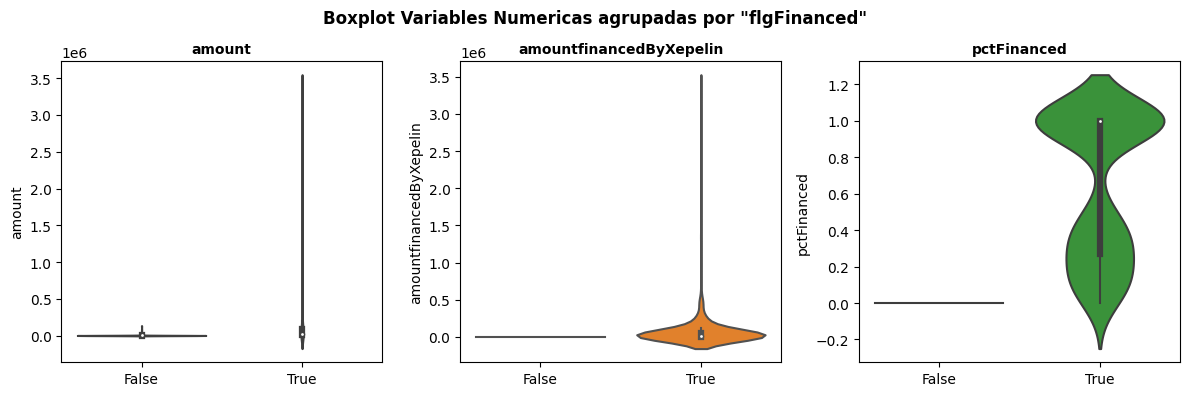

In [ ]:
# Boxplot para cada variable numérica agrupado por flgFinanced
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes = axes.flat
numeric_columns = df.select_dtypes(include=['float64', 'int']).columns


for i, column in enumerate(numeric_columns):
    sns.violinplot(
        data    = df,
        y       = column,
        x       = 'flgFinanced',
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        showfliers = False, #Eliminamos los outliers de la gráfica ya que no se puede observar la distribución
        ax      = axes[i]
    )
    axes[i].set_title(column, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top = 0.85)
fig.suptitle('Boxplot Variables Numericas agrupadas por "flgFinanced"', fontsize = 12, fontweight = "bold")
plt.show()

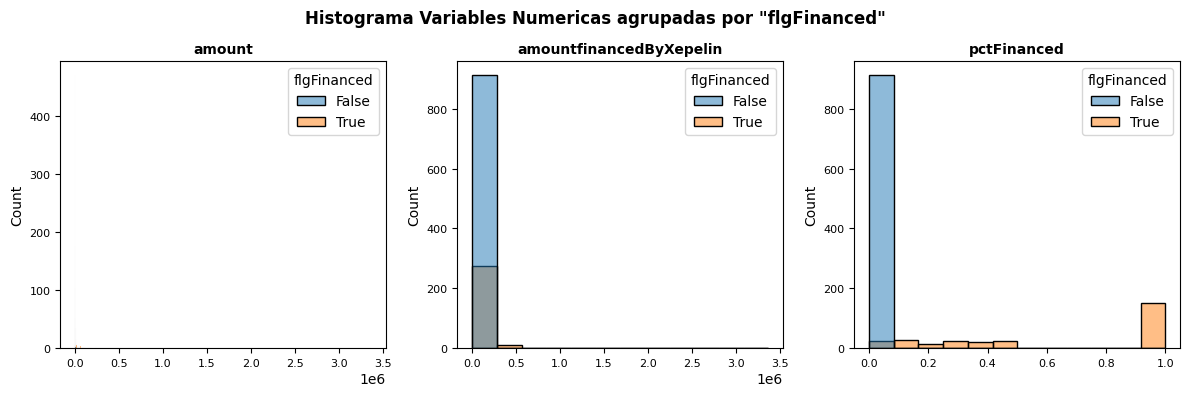

In [ ]:
# Histograma para cada variable numérica agrupado por flgFinanced
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes = axes.flat
numeric_columns = df.select_dtypes(include=['float64', 'int']).columns
plt.ticklabel_format(style='plain')

for i, column in enumerate(numeric_columns):
    sns.histplot(
        data    = df,
        x       = column,
        hue     = 'flgFinanced',
        color   = (list(plt.rcParams['axes.prop_cycle'])*3)[i]["color"],
        ax      = axes[i]
    )
    axes[i].set_title(column, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.85)
fig.suptitle('Histograma Variables Numericas agrupadas por "flgFinanced"', fontsize = 12, fontweight = "bold")
plt.show()

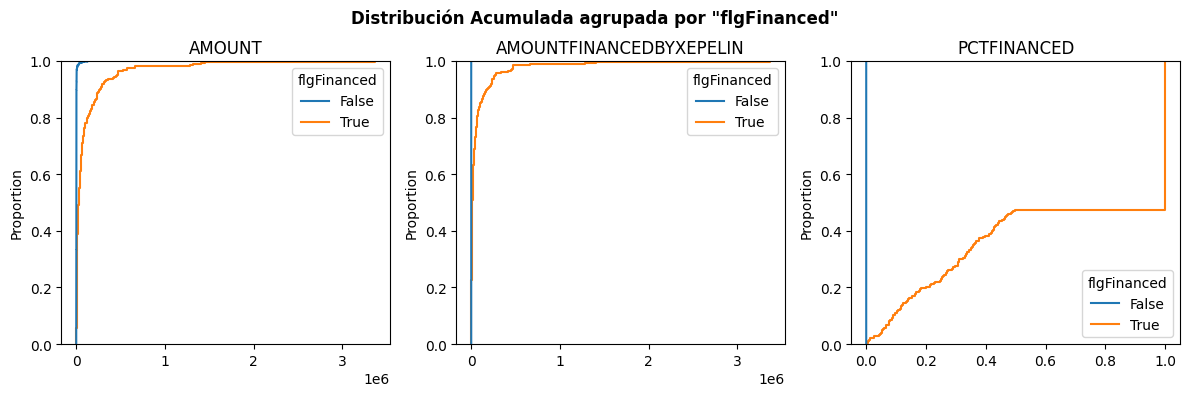

In [ ]:
# Distribución Acumulada para cada variable numérica agrupado por flgFinanced
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.subplots_adjust(hspace=0.5)
numeric_columns = df.select_dtypes(include=['float64', 'int']).columns

for f, ax in zip(numeric_columns, axs.ravel()):
    
    sns.ecdfplot(df, x=f, log_scale = False, hue = 'flgFinanced', ax=ax )


    ax.set_title(f.upper())
    ax.set_xlabel("")
fig.tight_layout()
plt.subplots_adjust(top = 0.85)
fig.suptitle('Distribución Acumulada agrupada por "flgFinanced"', fontsize = 12, fontweight = "bold")
plt.show()

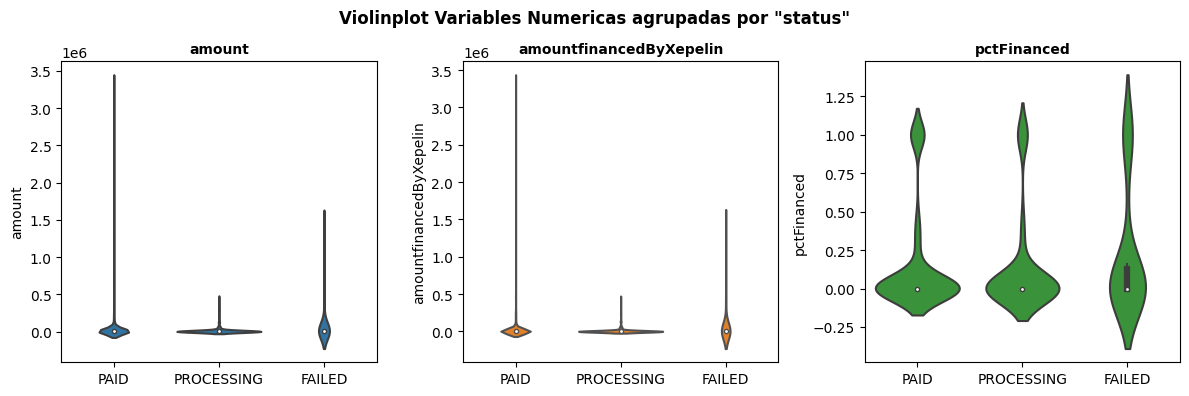

In [ ]:
# Boxplot para cada variable numérica agrupado por status
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes = axes.flat
numeric_columns = df.select_dtypes(include=['float64', 'int']).columns


for i, column in enumerate(numeric_columns):
    sns.violinplot(
        data    = df,
        y       = column,
        x       = 'status',
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        showfliers = False, #Eliminamos los outliers de la gráfica ya que no se puede observar la distribución
        ax      = axes[i]
    )
    axes[i].set_title(column, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top = 0.85)
fig.suptitle('Violinplot Variables Numericas agrupadas por "status"', fontsize = 12, fontweight = "bold")
plt.show()

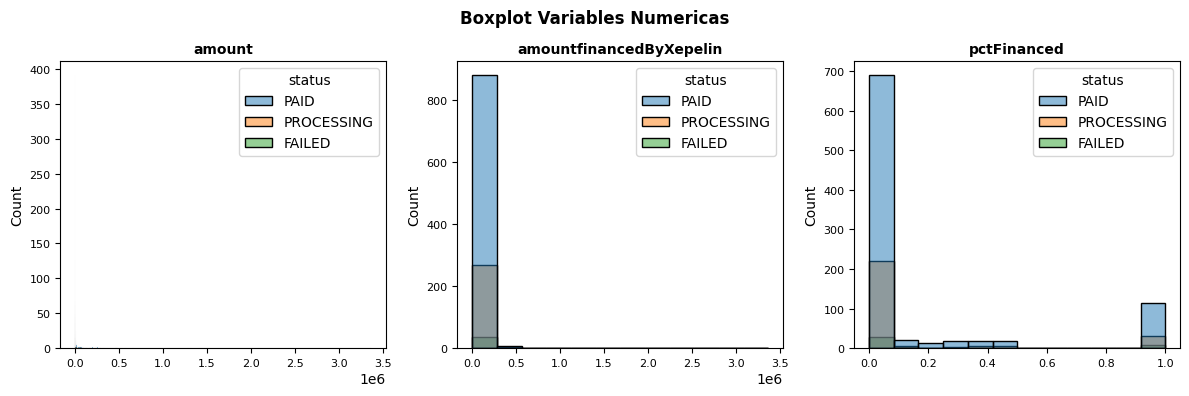

In [ ]:
# Histograma para cada variable numérica agrupado por status
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes = axes.flat
numeric_columns = df.select_dtypes(include=['float64', 'int']).columns
plt.ticklabel_format(style='plain')

for i, column in enumerate(numeric_columns):
    sns.histplot(
        data    = df,
        x       = column,
        hue     = 'status',
        color   = (list(plt.rcParams['axes.prop_cycle'])*3)[i]["color"],
        ax      = axes[i]
    )
    axes[i].set_title(column, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.85)
fig.suptitle('Histograma Variables Numericas agrupadas por "status"', fontsize = 12, fontweight = "bold")
plt.show()

## Distribución en el tiempo

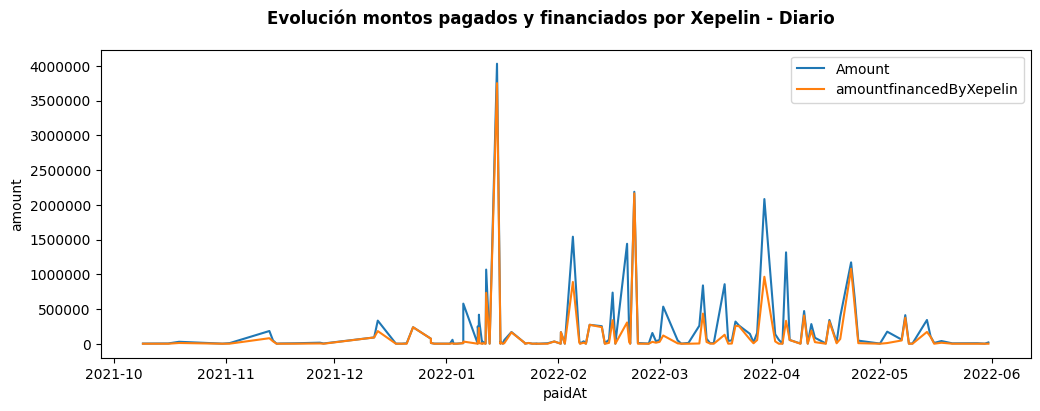

In [ ]:
# Lineplot valores totales en el tiempo
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(y = df['amount'],  x = df['paidAt'], data=df, ax=axs, 
             estimator=sum, ci=None, label='Amount')
sns.lineplot(y = df['amountfinancedByXepelin'],  x = df['paidAt'], data=df, ax=axs, 
             estimator=sum, ci=None, label='amountfinancedByXepelin')

plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Evolución montos pagados y financiados por Xepelin - Diario', fontsize = 12, fontweight = "bold")
plt.show()

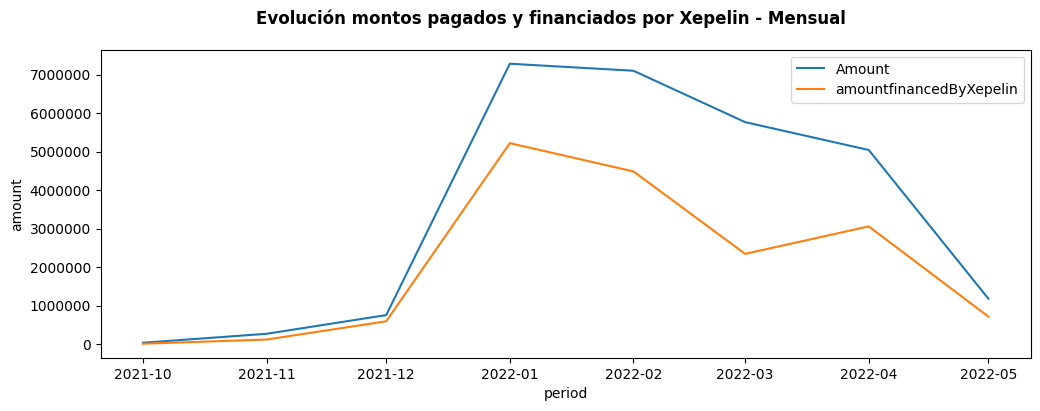

In [ ]:
# Lineplot valores totales en el tiempo
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.lineplot(y = df['amount'],  x = df['period'], data=df, ax=axs, 
             estimator=sum, ci=None, label='Amount')
sns.lineplot(y = df['amountfinancedByXepelin'],  x = df['period'], data=df, ax=axs, 
             estimator=sum, ci=None, label='amountfinancedByXepelin')

plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Evolución montos pagados y financiados por Xepelin - Mensual', fontsize = 12, fontweight = "bold")
plt.show()

# Time Series Analysis

## Load Data

In [88]:
# Imports the data, parsing the dates as a datetime object and setting it as an index
df = pd.read_csv("data/data_test(2).csv"
                 ,parse_dates=['paidAt'])

df = df[df['status'] == 'PAID']
df = df.drop(['status'], axis=1)

In [89]:
#generate columns with information infered by each date
df["week_year"] = df['paidAt'].dt.strftime('%Y-w%V')
df['period'] = df['paidAt'].dt.to_period('M').dt.to_timestamp()
df["day_of_week"] = df['paidAt'].dt.strftime('%A')

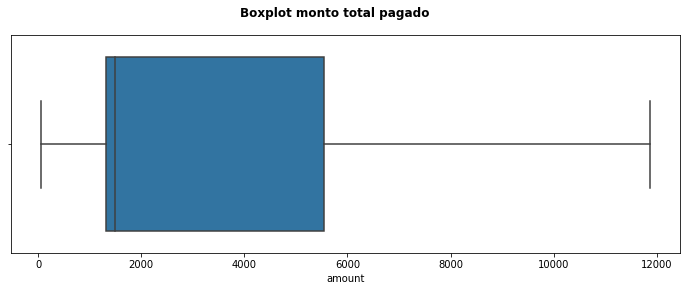

In [90]:
# Lineplot valores totales en el tiempo
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.boxplot(x = df["amount"],  showfliers=False)

fig.suptitle('Boxplot monto total pagado', fontsize = 12, fontweight = "bold")
plt.show()

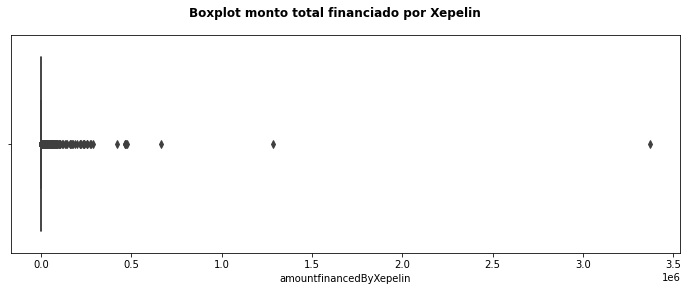

In [91]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

sns.boxplot(x = df["amountfinancedByXepelin"])


fig.suptitle('Boxplot monto total financiado por Xepelin', fontsize = 12, fontweight = "bold")
plt.show()

## Estacionalidad 'Amount'

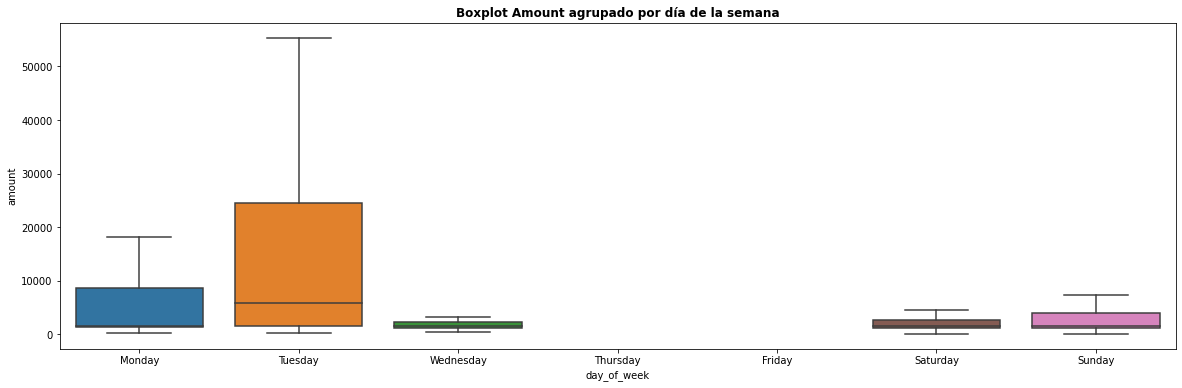

In [92]:
# Estacionalidad por día de la Semana
# ==============================================================================
plt.subplots(figsize = (20,6))
sns.boxplot(x = df["day_of_week"], 
            y = df["amount"],
            order = calendar.day_name,
            showfliers=False)
plt.title('Boxplot Amount agrupado por día de la semana', fontsize = 12, fontweight = "bold")
plt.show()

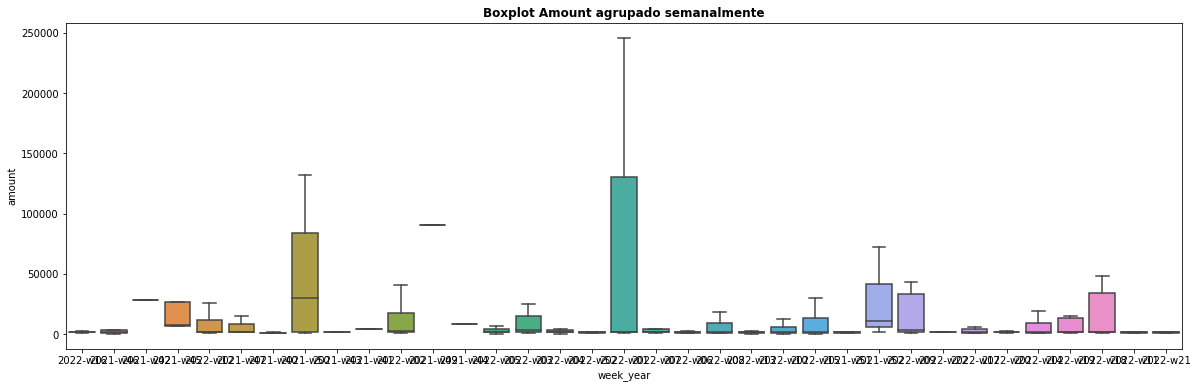

In [93]:
# Estacionalidad Semanal
# ==============================================================================
plt.subplots(figsize = (20,6))
sns.boxplot(x = df["week_year"], 
            y = df["amount"],           
            showfliers=False)
plt.title('Boxplot Amount agrupado semanalmente', fontsize = 12, fontweight = "bold")
plt.show()

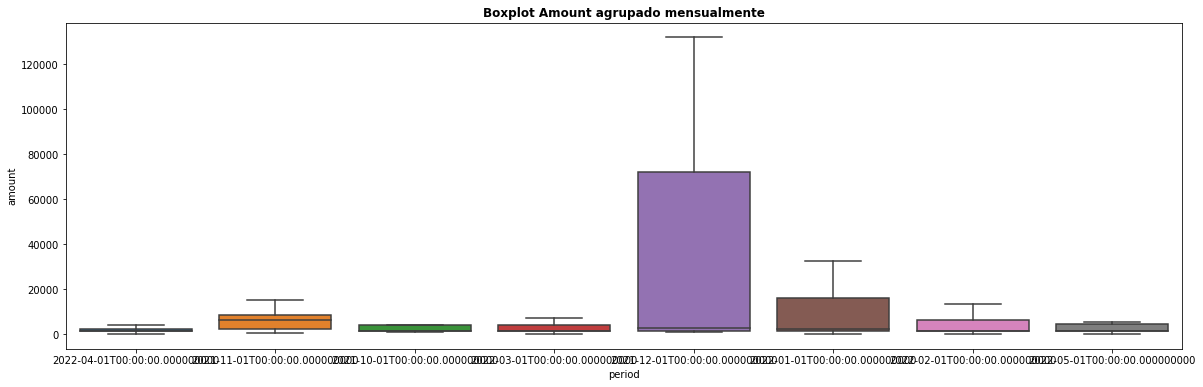

In [94]:
# Estacionalidad Mensual
# ==============================================================================
plt.subplots(figsize = (20,6))
sns.boxplot(x = df["period"], 
            y = df["amount"],           
            showfliers=False)
plt.title('Boxplot Amount agrupado mensualmente', fontsize = 12, fontweight = "bold")
plt.show()

## Time Series Decomposition

In [95]:
df_time = pd.read_csv("data/data_test(2).csv"
                 ,parse_dates=['paidAt']
                 ,index_col=['paidAt'])

In [96]:
df_time = df_time.groupby([df_time.index])['amount'].sum()
df_time = df_time.to_frame(name="amount")

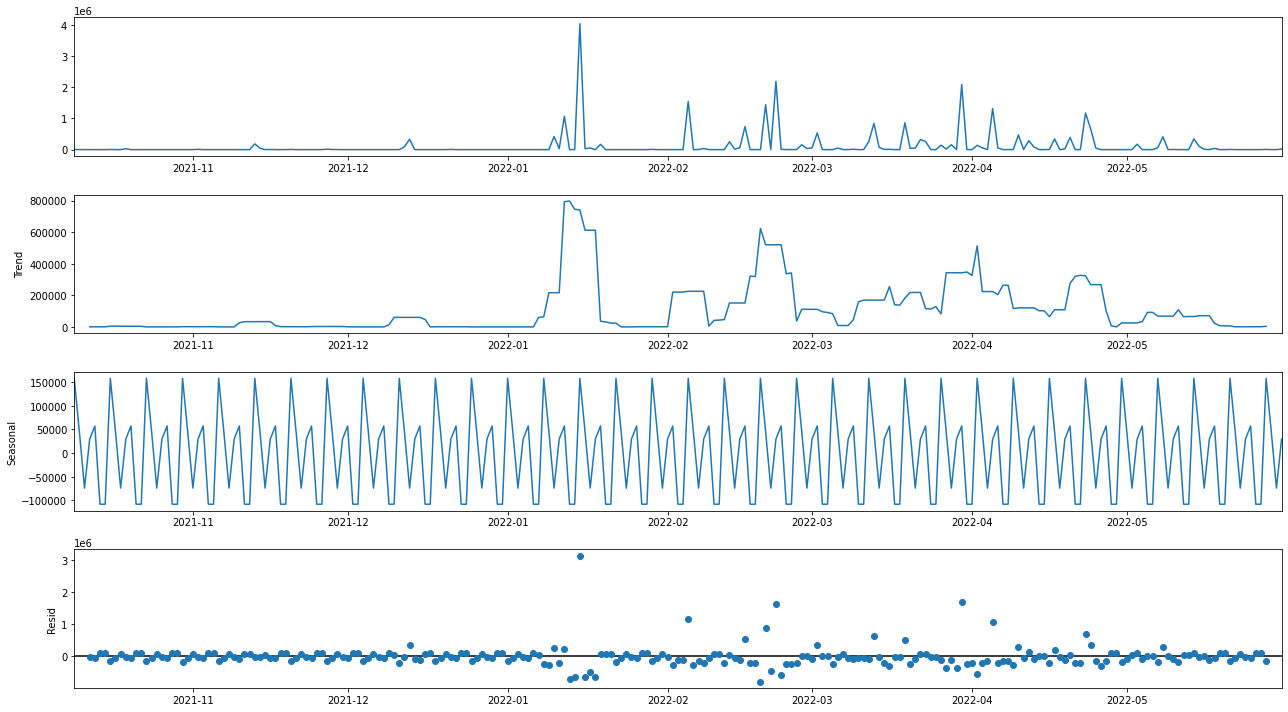

In [97]:
# Descomposición de series diarias
# ==============================================================================

decompose_df = df_time.asfreq('D')
decompose_df["amount_dec"] = decompose_df['amount'].fillna(0) # assuming that dates not present in the data no sales were made
decompose_df = decompose_df[["amount_dec"]]

decomposition = sm.tsa.seasonal_decompose(decompose_df, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(18,10))
    decomp = decomposition.plot()

In [ ]:
# Descomposición de series semanales (no se puede realizar)
# ==============================================================================

df_weekly = pd.DataFrame(df_time["amount"].resample("W-FRI").sum())
decompose_df_w = df_weekly[["amount"]]

decomposition = sm.tsa.seasonal_decompose(decompose_df_w, model='additive', extrapolate_trend = 3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,10))
    decomp = decomposition.plot()
    decomp.suptitle('nb_of_policies Decomposition weekly', fontsize=22)

In [100]:
def stationary_check(series, k_diff) -> str:
    """This function uses the Augmented DF test to check if
    time series is stationary"""
    
    ts = diff(series,k_diff = k_diff)
    res = adfuller(ts.dropna(),autolag='AIC')

    return f"P-Value is {res[1]}, therefore there's{' no' if res[1] > .05 else ''} evidence that supports the series is stationary"

In [101]:
df_monthly = pd.DataFrame(df_time["amount"].resample("M").sum())

In [102]:
# Check for Stationarity with ADF test

stationary_check(df_monthly,k_diff=0)

"P-Value is 0.13002576731218102, therefore there's no evidence that supports the series is stationary"

## Estacionalidad 'amountfinancedByXepelin'

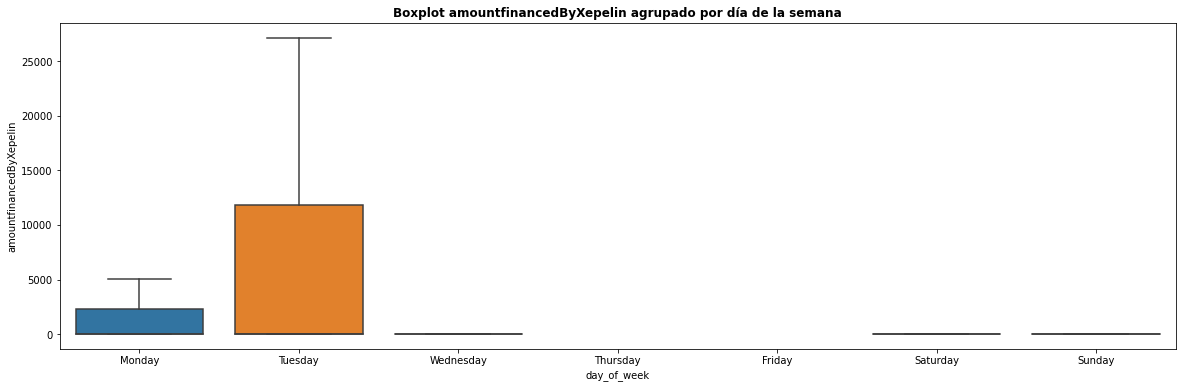

In [103]:
# Estacionalidad por día de la Semana
# ==============================================================================
plt.subplots(figsize = (20,6))
sns.boxplot(x = df["day_of_week"], 
            y = df["amountfinancedByXepelin"],
            order = calendar.day_name,
            showfliers=False)
plt.title('Boxplot amountfinancedByXepelin agrupado por día de la semana', fontsize = 12, fontweight = "bold")
plt.show()

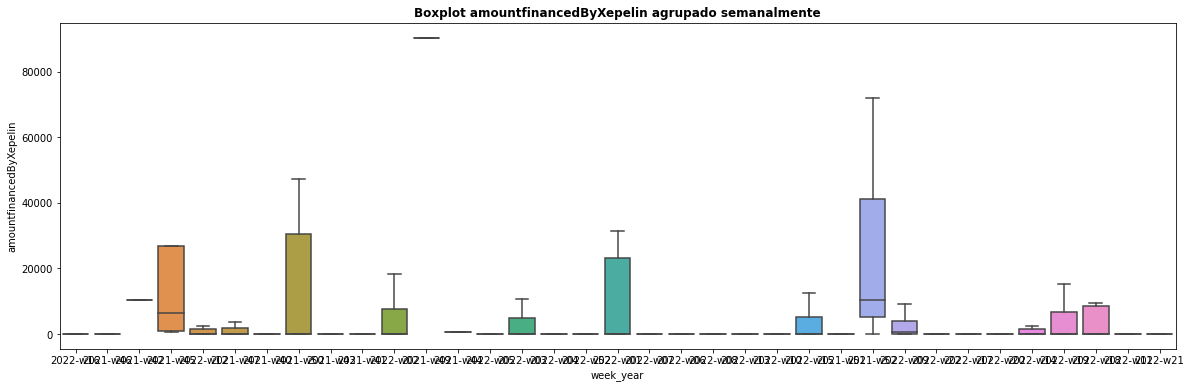

In [104]:
# Estacionalidad Semanal
# ==============================================================================
plt.subplots(figsize = (20,6))
sns.boxplot(x = df["week_year"], 
            y = df["amountfinancedByXepelin"],           
            showfliers=False)
plt.title('Boxplot amountfinancedByXepelin agrupado semanalmente', fontsize = 12, fontweight = "bold")
plt.show()

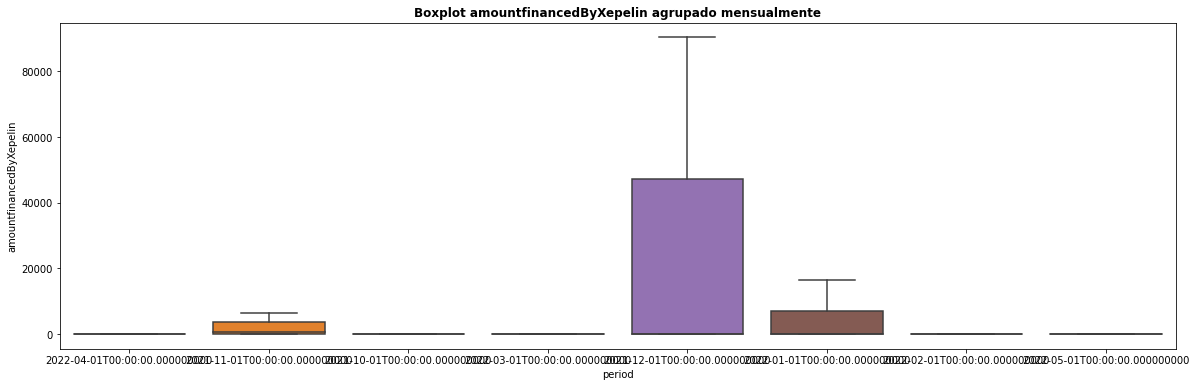

In [105]:
# Estacionalidad Mensual
# ==============================================================================
plt.subplots(figsize = (20,6))
sns.boxplot(x = df["period"], 
            y = df["amountfinancedByXepelin"],           
            showfliers=False)
plt.title('Boxplot amountfinancedByXepelin agrupado mensualmente', fontsize = 12, fontweight = "bold")
plt.show()

## Time Series Decomposition

In [109]:
df_time = pd.read_csv("data/data_test(2).csv"
                 ,parse_dates=['paidAt']
                 ,index_col=['paidAt'])

In [110]:
df_time = df_time.groupby([df_time.index])['amountfinancedByXepelin'].sum()
df_time = df_time.to_frame(name="amountfinancedByXepelin")

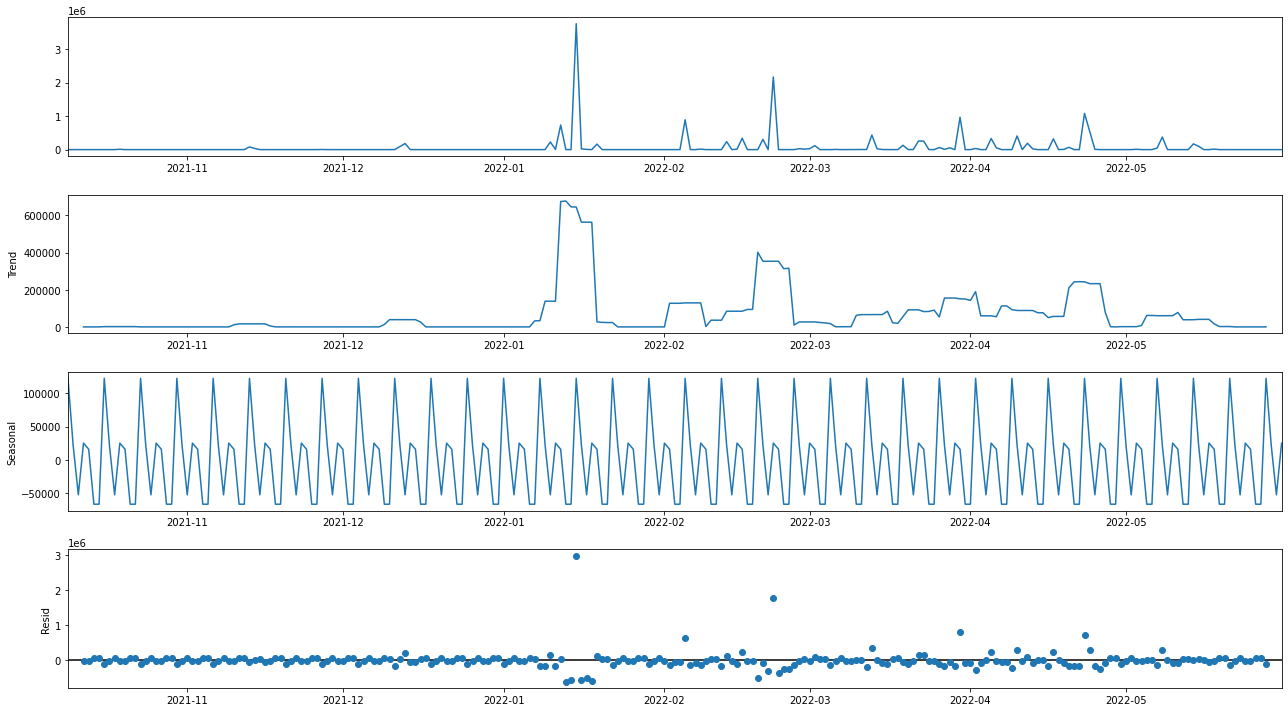

In [111]:
# Descomposición de series diarias
# ==============================================================================

decompose_df = df_time.asfreq('D')
decompose_df["amountfinancedByXepelin_dec"] = decompose_df['amountfinancedByXepelin'].fillna(0) # assuming that dates not present in the data no sales were made
decompose_df = decompose_df[["amountfinancedByXepelin_dec"]]

decomposition = sm.tsa.seasonal_decompose(decompose_df, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(18,10))
    decomp = decomposition.plot()

In [112]:
df_monthly = pd.DataFrame(df_time["amountfinancedByXepelin"].resample("M").sum())

In [113]:
# Check for Stationarity with ADF test

stationary_check(df_monthly,k_diff=0)

"P-Value is 0.17041018580432987, therefore there's no evidence that supports the series is stationary"